<a href="https://colab.research.google.com/github/Sreekar22/Denoising_Image_using_Auto_Encoders/blob/main/Denoising_Image_using_Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **For Dataset vist below link:**
https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Load Dataset
## Now, we import required libraries
*   To read the CSV data, you will need pandas.read_csv
*   For plotting,use matpliot
*   For splitting into train and test set use sklearn
*   For deep learning layers use tendorflow and keras
*   For maths operation use numpy


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
%matplotlib inline
sns.set(style = 'white', context = 'notebook', palette = 'deep')
np.random.seed(42)

## To read the CSV data, you will need pandas.read_csv. It will read the data into the Pandas data frame.

In [ ]:
train = pd.read_csv("/content/drive/My Drive/fashion-mnist_test.csv")
test = pd.read_csv("/content/drive/My Drive/fashion-mnist_train.csv")

## Check how pixels look like in the data frame. train.head() will show the first five columns of the data frame.

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#check for null or missing values in column list
train.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

## Here we can see that our dataset is onpoint. This is rare as it has no missing vales



In [ ]:
train.shape#So there are 785 total pixels present in the data of size 28x28. A black and white image is in a 2D array form.

(10000, 785)

# Preparing the Image Data
The data contains black and white images with unsigned integers of the range 0 to 255.

Here there is a need for scaling the image. Normalize the pixel values by rescaling them to the range 0-1. The first step is to convert the data type from the data frame and series to NumPy ndarray.

In [ ]:
y_train = train["label"]
x_train = train.drop(labels = ["label"], axis = 1)

print(type(x_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
x_train = x_train.astype('float')/255.

In [ ]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Splitting the data into trainng set and testing set
We split the dataset into 20/80
Also we use stratify to maintain the original distribution of Dependent variable as of original set

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
x_train_size = len(x_train)
x_val_size = len(x_val)

print(x_train_size)
print(x_val_size)

8000
2000


# Adding Noise: Denoising Autoencoder
* To develop a generalized model, a bit of noise is added to the input data to make it corrupt. The uncorrupted data is maintained, and it acts as the output. Here the model cannot memorize the training data and maps out the result as input. Output targets are different. This forces the model to map the input data to a lower-dimension manifold (a concentration point for input data).


* Add synthetic noise by applying random data on the image data. You will need to normalize that new form of random image too. To achieve that, multiply the random noise by 0.9 and clip the range between 0 to 1. You may also use the Gaussian noise matrix and notice the difference.

In [ ]:
#method-1
x_train_noisy = x_train + np.random.rand(x_train_size, 784) * 0.9
x_val_noisy = x_val + np.random.rand(x_val_size, 784) * 0.9

#method-2: Adding Gaussian Noise
# x_train_noisy = x_train + 0.75 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
# x_val_noisy = x_val + 0.75 * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)


## Only for the visualization purpose, the image is reshaped from 1D array to 2D array, 784 to (28,28).

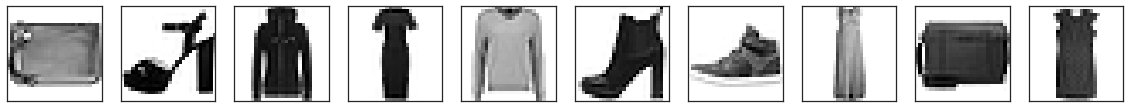

In [ ]:
def plot(x, p , labels = False):
  plt.figure(figsize = (20,2))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x[i].reshape(28,28), cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
  if labels:
    plt.xlabel(np.argmax(p[i]))
  plt.show()
  return
plot(x_train, None)

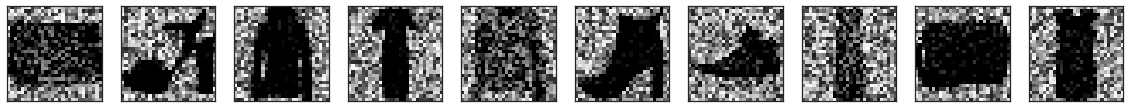

In [ ]:
plot(x_train_noisy,None)

The input size is of a 1D array. Notice that Dense layer 64 produces the bottleneck. The final layer at the decoder end gives the output of 784 units. The sigmoid function gives out the value between 0 and 1. This layer decides whether to consider the noise pixel or not.

In [ ]:
input_image = Input(shape = (784, ) )

encoded = Dense(512, activation = 'relu')(input_image)
encoded = Dense(512, activation = 'relu')(encoded)
encoded = Dense(256, activation = 'relu')(encoded)
encoded = Dense(256, activation = 'relu')(encoded)
encoded = Dense(64, activation = 'relu')(encoded)

decoded = Dense(512, activation = 'relu')(encoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss= 'binary_crossentropy' , optimizer = 'adam')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 512)               33280 

In [ ]:
import tensorflow as tf
history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, shuffle = True, validation_split=0.2)

Epoch 1/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2773 - val_loss: 0.2959
Epoch 2/100
50/50 [==============================] - 2s 34ms/step - loss: 0.2772 - val_loss: 0.2964
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.2770 - val_loss: 0.2956
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.2777 - val_loss: 0.2976
Epoch 5/100
50/50 [==============================] - 2s 35ms/step - loss: 0.2772 - val_loss: 0.2960
Epoch 6/100
50/50 [==============================] - 2s 34ms/step - loss: 0.2771 - val_loss: 0.2960
Epoch 7/100
50/50 [==============================] - 2s 34ms/step - loss: 0.2769 - val_loss: 0.2961
Epoch 8/100
50/50 [==============================] - 2s 35ms/step - loss: 0.2765 - val_loss: 0.2962
Epoch 9/100
50/50 [==============================] - 3s 62ms/step - loss: 0.2765 - val_loss: 0.2965
Epoch 10/100
50/50 [==============================] - 3s 63ms/step - loss: 0.2769 - val_loss: 0.2963

# Producing a Denoised Image
Below you can see how well denoised images were produced from noisy ones present in x_val. There are three outputs: original test image, noisy test image, and denoised test image form autoencoders.

In [ ]:
preds = autoencoder.predict(x_val_noisy)

63/63 [==============================] - 0s 5ms/step


Test Image


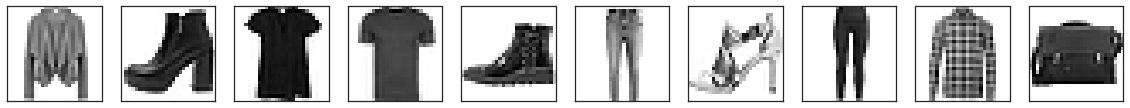

In [ ]:
print("Test Image")
plot(x_val, None)

Noisy Image


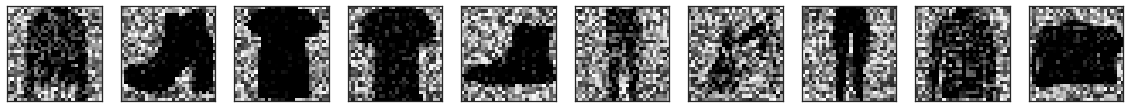

In [ ]:
print("Noisy Image")
plot(x_val_noisy, None)

Denoised Image


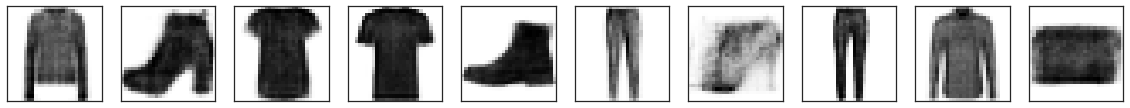

In [ ]:
print("Denoised Image")
plot(preds, None)

In [ ]:
def plot_loss(history, x = 'loss', y = 'val_loss'):
  fig, ax = plt.subplots( figsize=(20,10))
  ax.plot(history.history[x])
  ax.plot(history.history[y])
  plt.title('Model Loss')
  plt.ylabel(y)
  plt.xlabel(x)
  plt.legend(['Train', 'Val'], loc='upper left')
  ax.grid(color='black')
  plt.show()

## Plotting the loss

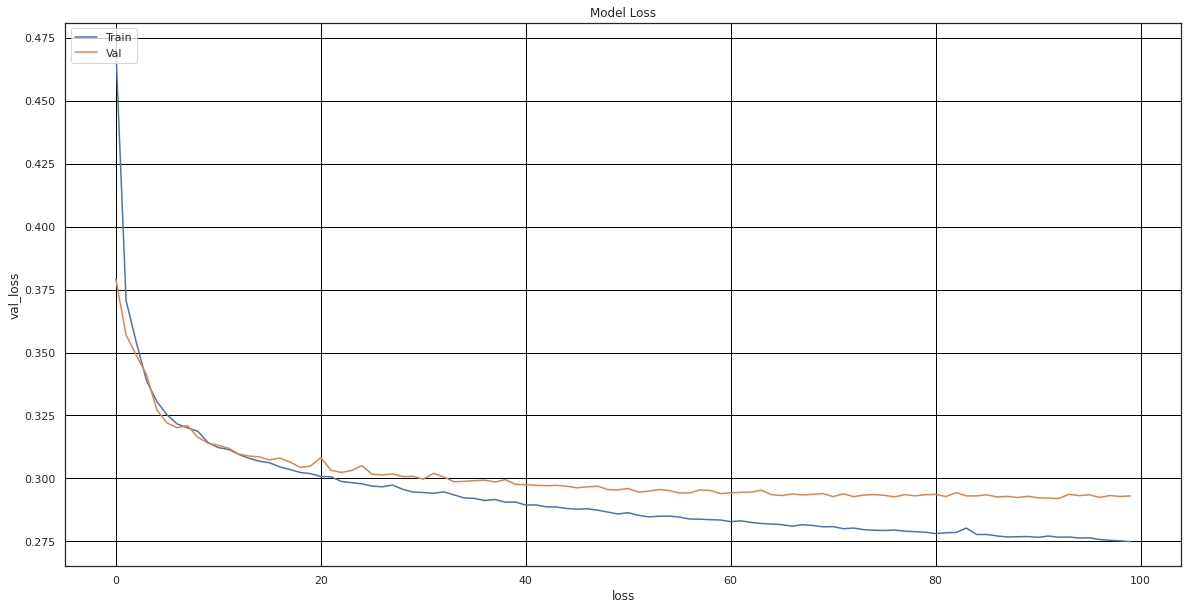

In [ ]:
plot_loss(history)

# Conclusion
This model works good upto certain point,but eventually it showing overfitting isuue
So,there is still scope for improvement
we can change the hyperparameters and observe how model works
